In [228]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from collections import defaultdict
import dateutil.parser
from pprint import pprint
import pandas
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from copy import deepcopy

%matplotlib inline

### Helper methods for BeautifulSoup ###

In [2]:
def get_soup_ps(prefix, suffix):
    response = requests.get(prefix + suffix)   
    page = response.text
    soup = BeautifulSoup(page, 'html.parser')
    return soup

def get_soup_url(url):
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, 'html.parser')
    return soup

## Gather the links to the top movies of all time ##

In [3]:
movie_prefix = 'http://www.boxofficemojo.com/alltime/domestic.htm?page=' 
partial_movie_suffix = '&p=.htm'
top_movie_links = set()

for page in range(1,41):
    full_movie_suffix = str(page) + partial_movie_suffix
    soup = get_soup_ps(movie_prefix, full_movie_suffix)
    for element in soup.find_all('a'):
        link = element.get('href')
        if link.startswith('/movies/?id'):
            top_movie_links.add(link)
    if '/movies/?id=michelledarnell.htm' in top_movie_links:
        top_movie_links.remove('/movies/?id=michelledarnell.htm')

In [4]:
# Number of movies in database
print len(top_movie_links)

3902


In [ ]:
# Smaller set of movies to test data collection on
test_movie_links = {x for x in top_movie_links if 'horse' in x}
print test_movie_links

### Helper methods to gather data on given movie ###

In [5]:
def get_movie_value(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    # this works for most of the values
    next_sibling = obj.findNextSibling()
    if next_sibling:
        return next_sibling.text 
    else:
        next_sibling = obj.find_parent().findNextSibling()
        return next_sibling

    
def get_movie_values_odd(soup, field_name):
    '''Grabs value from boxofficemojo HTML in 
    Domestic Summary box
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    try:
        div_with_stats = soup.find_all('div',class_='mp_box_content')[1]
        flag = False
        obj = ''
        for element in div_with_stats.find_all('td'):
            if flag:
                obj = element.text
                return obj
            if field_name in str(element):
                flag = True
    except:
        return None

            
def get_weekly_rev(soup):
    '''Retrieves weekly revenue for given movie
    
    Returns a list of the weekly revenue,
    ordered by week since release
    '''
    try:
        weekly_rev_list = []
        for element in soup.find_all('center')[1]:
            box = element.find_all('font')
            for thing in box:
                if '$' in thing.text:
                    weekly_rev_list.append(thing.text)
        return weekly_rev_list[0::3]
    except:
        return None


def to_date(datestring):
    try:
        date = dateutil.parser.parse(datestring)
        return date
    except:
        return datestring
    

def money_to_int(moneystring):
    try:
        moneystring = moneystring.replace('$', '').replace(',', '')
        if 'mil' in moneystring:
            moneystring_digits = moneystring.split(' ')[0].strip()
            return int(moneystring_digits) * 1000000
        return int(moneystring)
    except:
        return None
    
    
def runtime_to_minutes(runtimestring):
    try:
        runtime = runtimestring.split()
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

    
def theaters_to_int(theaterstring):
    try:
        theaters = int(str(theaterstring.split()[0]).replace(',',''))
        return theaters
    except:
        return None


def release_time_to_days(releasestring):
    try:
        days = int(releasestring.split()[0])
        return days
    except:
        return None

## Collect data from BoxOfficeMojo ##

Output is a list of dictionaries containing all data for a single movie

In [13]:
headers = ['movieid','movie title', 'domestic total gross',
           'release date', 'runtime (mins)', 'rating', 
           'genre', 'production budget', 'distributor',
            'opening weekend revenue', 'number of theaters',
            'time in theaters (days)']

base_url = 'http://www.boxofficemojo.com/'

movie_data = []
rev_data = {}
missing_links = []

counter = 1

time_count = 0

for movie in top_movie_links:
    try:
        if time_count % 50 == 0: print time_count
        time_count += 1

        # Create a movieid
        movieid = counter
        counter += 1


        # Create dictionary of movieid to list of weekly revenues
        movie_link_split = movie.split('?')
        weekly_suffix = movie_link_split[0] + '?page=weekly&' + movie_link_split[1]
        weekly_soup = get_soup_ps(base_url, weekly_suffix)

        weekly_revenue = get_weekly_rev(weekly_soup)

        rev_data[movieid] = weekly_revenue


        # Create list of movie data dictionarys
        soup = get_soup_ps(base_url, movie)
        adj_soup = get_soup_ps(base_url, movie + '&adjust_yr=2016&p=.htm')

        raw_title_string = soup.find('title').text
        title = raw_title_string.split('(')[0].strip()

        raw_release_date = get_movie_value(soup,'Release Date')
        release_date = to_date(raw_release_date)

        raw_domestic_total_gross = get_movie_value(adj_soup,'Domestic Total')
        domestic_total_gross = money_to_int(raw_domestic_total_gross)

        raw_runtime = get_movie_value(soup,'Runtime')
        runtime = runtime_to_minutes(raw_runtime)

        rating = get_movie_value(soup,'MPAA Rating')

        genre = get_movie_value(soup, 'Genre:')

        raw_prod_budget = get_movie_value(soup, 'Production Budget')
        prod_budget = money_to_int(raw_prod_budget)

        distributor = get_movie_value(soup, 'Distributor:')

        raw_opening_weekend = get_movie_values_odd(adj_soup, 'Opening')
        opening_weekend = money_to_int(raw_opening_weekend)

        raw_widest_release = get_movie_values_odd(soup, 'Widest')
        widest_release = theaters_to_int(raw_widest_release)

        raw_realease_time = get_movie_values_odd(soup, 'In Release')
        release_time = release_time_to_days(raw_realease_time)

        raw_close_date = get_movie_values_odd(soup, 'Close')
        close_date = to_date(raw_close_date)

        # Calculate days in theaters if not given
        if release_time == None and close_date != None:
            day_diff = close_date - release_date
            release_time = release_time_to_days(str(day_diff))
        elif release_time == None and close_date == None and weekly_revenue != None:
            num_weeks = len(weekly_revenue)
            release_time = num_weeks * 7



        movie_dict = dict(zip(headers, [movieid, 
                                        title,
                                        domestic_total_gross,
                                        release_date,
                                        runtime,
                                        rating,
                                        genre,
                                        prod_budget,
                                        distributor,
                                        opening_weekend,
                                        widest_release,
                                        release_time]))

        movie_data.append(movie_dict) 
    
    except:
        print 'ChunkedEncodingError'
        missing_links.append(movie)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
ChunkedEncodingError
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900


In [18]:
# print len(missing_links)

1


In [ ]:
# print movie_data

In [28]:
# Check that the data is all there
print len(rev_data)
print len(movie_data)

# Sanity check what the longest list is
max_count = 0
for movid,weekly_list in rev_data.items():
    try:
        count = len(weekly_list)
        if count > max_count:
            max_count = count
    except:
        continue
print max_count

3901
3901
671


In [29]:
# test_rev_data = {k: rev_data[k] for k in rev_data.keys()[:2]}
# print pprint(test_rev_data)

{1: [u'$7,233,595',
     u'$8,594,407',
     u'$7,693,516',
     u'$4,614,709',
     u'$3,901,369',
     u'$2,760,709',
     u'$2,090,672',
     u'$1,383,818'],
 2: [u'$22,745,474',
     u'$20,277,293',
     u'$18,949,513',
     u'$14,945,444',
     u'$11,494,773',
     u'$7,763,833',
     u'$5,970,181',
     u'$4,021,083',
     u'$2,683,780',
     u'$2,264,631']}
None


In [30]:
with open('movie_data2.pickle', 'wb') as handle:
    pickle.dump(movie_data, handle)

with open('rev_data2.pickle', 'wb') as handle:
    pickle.dump(movie_data, handle)

# Input movie data into pandas DataFrame #

In [92]:
moviedf = pd.DataFrame(movie_data)

### Clean data ###

In [41]:
print moviedf.dtypes

distributor                        object
domestic total gross              float64
genre                              object
movie title                        object
number of theaters                float64
opening weekend revenue           float64
production budget                 float64
rating                             object
release date               datetime64[ns]
runtime (mins)                    float64
time in theaters (days)           float64
dtype: object


In [47]:
moviedf.count(axis=0)

distributor                3898
domestic total gross       3898
genre                      3898
movie title                3901
number of theaters         3630
opening weekend revenue    3296
production budget          2024
rating                     3898
release date               3898
runtime (mins)             3897
time in theaters (days)    3900
dtype: int64

In [140]:
moviedf = moviedf[moviedf['time in theaters (days)'] < 500]
# Removed ~10 rows - all but one being IMAX movies

In [303]:
# Cell to look at outliers
# m = moviedf[moviedf['movieid'] == 792]
# print m
moviedf = moviedf[moviedf['movie title'] != 'Red Dawn']

In [342]:
moviedf[18:19]

,distributor,domestic total gross,genre,movie title,movieid,number of theaters,opening weekend revenue,production budget,rating,release date,runtime (mins),time in theaters (days),release month
18,Universal,109237700.0,Sports Comedy,Slap Shot,19,NaN,NaN,NaN,R,1977-02-25,122.0,0.0,2.0


In [298]:
moviedf.describe()

,domestic total gross,movieid,number of theaters,opening weekend revenue,production budget,runtime (mins),time in theaters (days),release month
count,3.874000e+03,3876.000000,3606.000000,3.284000e+03,2.024000e+03,3873.000000,3876.000000,3874.000000
mean,9.662992e+07,1950.676213,2244.049085,2.359963e+07,5.481129e+07,108.829589,76.900413,7.020909
std,9.912104e+07,1127.581707,920.533453,2.303013e+07,4.625874e+07,18.741207,52.298004,3.447639
min,1.263660e+07,1.000000,15.000000,4.960000e+04,1.500000e+04,40.000000,0.000000,1.000000
25%,3.775238e+07,973.750000,1502.500000,1.061198e+07,2.200000e+07,96.000000,37.750000,4.000000
50%,6.287815e+07,1948.500000,2307.000000,1.651565e+07,4.000000e+07,106.000000,70.000000,7.000000
75%,1.159403e+08,2928.250000,2954.500000,2.771868e+07,7.500000e+07,118.000000,108.000000,10.000000
max,1.239014e+09,3902.000000,4468.000000,2.479667e+08,3.000000e+08,227.000000,469.000000,12.000000


In [255]:
moviedf.head()

,distributor,domestic total gross,genre,movie title,movieid,number of theaters,opening weekend revenue,production budget,rating,release date,runtime (mins),time in theaters (days),release month
0,Orion Pictures,90944400.0,Comedy,Dirty Rotten Scoundrels,1,1515.0,8129500.0,NaN,PG,1988-12-16,110.0,56.0,12.0
1,Fox,252358600.0,Action Thriller,Speed,2,2169.0,30088300.0,30000000.0,R,1994-06-10,116.0,70.0,6.0
2,Paramount,48884600.0,Comedy,The Out-of-Towners,3,2128.0,14084800.0,75000000.0,PG-13,1999-04-02,90.0,105.0,4.0
3,Universal,39263600.0,War Romance,Captain Corelli's Mandolin,4,1612.0,11081500.0,57000000.0,R,2001-08-17,129.0,63.0,8.0
4,Paramount,108640100.0,Comedy,"Planes, Trains and Automobiles",5,1684.0,15596500.0,NaN,R,1987-11-25,92.0,77.0,11.0


## Adding Additional Features ##

In [160]:
moviedf['release month'] = moviedf['release date'].dt.month

/Users/MelanieAppleby/anaconda/envs/benson/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Input revenue data into pandas DataFrame ###

In [383]:
revdf = pd.DataFrame.from_dict({k : pd.Series(v) for k,v in rev_data.items()}, 
                                     orient='index')

In [384]:
revdf.head()

,0,1,2,3,4,5,6,7,8,9,...,661,662,663,664,665,666,667,668,669,670
1,"$7,233,595","$8,594,407","$7,693,516","$4,614,709","$3,901,369","$2,760,709","$2,090,672","$1,383,818",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"$22,745,474","$20,277,293","$18,949,513","$14,945,444","$11,494,773","$7,763,833","$5,970,181","$4,021,083","$2,683,780","$2,264,631",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"$11,192,311","$6,196,922","$3,903,740","$2,577,108","$1,404,641","$997,065","$719,745","$373,035","$201,881","$137,653",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"$10,086,280","$5,634,040","$4,602,715","$2,025,360","$1,467,950","$1,163,835","$397,145","$115,500","$51,070",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"$3,121,760","$7,924","$5,851","$3,130","$2,759","$4,243","$3,014","$2,248","$1,730","$1,349",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [387]:
index_list = revdf.index.tolist()
print index_list[:100]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]


In [388]:
# Convert items to floats
rev_list = []
iterator = revdf.iterrows()
for item in iterator:
    num_list = []
    for num in item[1]:
        money = money_to_int(str(num))
        num_list.append(money)
    rev_list.append(num_list)

In [389]:
revdf = pd.DataFrame(rev_list, index=index_list)

In [390]:
revdf.head()

,0,1,2,3,4,5,6,7,8,9,...,661,662,663,664,665,666,667,668,669,670
1,7233595,8594407.0,7693516.0,4614709.0,3901369.0,2760709.0,2090672.0,1383818.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22745474,20277293.0,18949513.0,14945444.0,11494773.0,7763833.0,5970181.0,4021083.0,2683780.0,2264631.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11192311,6196922.0,3903740.0,2577108.0,1404641.0,997065.0,719745.0,373035.0,201881.0,137653.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10086280,5634040.0,4602715.0,2025360.0,1467950.0,1163835.0,397145.0,115500.0,51070.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3121760,7924.0,5851.0,3130.0,2759.0,4243.0,3014.0,2248.0,1730.0,1349.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [411]:
print revdf.index.tolist()[:100]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]


In [393]:
revdf.to_csv('csv/init_float_revdf.csv',encoding='utf-8')

In [413]:
# revdf_nulls = revdf[revdf.isnull().all(axis=1)]
# revdf_nulls.head()

In [ ]:
# weekly_rev_df.drop(791, inplace=True)

In [324]:
# weekly_rev_df.dropna(axis=1, how='all', inplace=True)

In [343]:
# weekly_rev_df.dropna(axis=0, how='all', inplace=True)

In [352]:
# Save DFs
# moviedf.to_csv('csv/moviedf2.csv',encoding='utf-8')
# weekly_rev_df.to_csv('csv/weekly_rev_df1.csv',encoding='utf-8')

In [404]:
# Includes the movie indexes to include, where weekly revenue is not null
# index_list = weekly_rev_df.index.tolist()
# print index_list[:100]

In [405]:
# moviedf.index

In [358]:
# moviedf_clean = moviedf[moviedf.index.isin(index_list)]

In [406]:
# movie_index_list = moviedf_clean.index.tolist()
# print movie_index_list[:100]

In [407]:
# print movie_index_list == index_list

In [408]:
# print len(movie_index_list)
# print len(index_list)

In [409]:
print len(moviedf.index.tolist())
print len(revdf.index.tolist())

3874
3652


In [414]:
revdf.head()

,0,1,2,3,4,5,6,7,8,9,...,661,662,663,664,665,666,667,668,669,670
1,7233595,8594407.0,7693516.0,4614709.0,3901369.0,2760709.0,2090672.0,1383818.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22745474,20277293.0,18949513.0,14945444.0,11494773.0,7763833.0,5970181.0,4021083.0,2683780.0,2264631.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11192311,6196922.0,3903740.0,2577108.0,1404641.0,997065.0,719745.0,373035.0,201881.0,137653.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10086280,5634040.0,4602715.0,2025360.0,1467950.0,1163835.0,397145.0,115500.0,51070.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3121760,7924.0,5851.0,3130.0,2759.0,4243.0,3014.0,2248.0,1730.0,1349.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [415]:
revdf_exnullrows = revdf.dropna(axis=1, how='all')

In [418]:
print len(revdf_exnullrows)
revdf_exnullrows.head()

3652


,0,1,2,3,4,5,6,7,8,9,...,661,662,663,664,665,666,667,668,669,670
1,7233595,8594407.0,7693516.0,4614709.0,3901369.0,2760709.0,2090672.0,1383818.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22745474,20277293.0,18949513.0,14945444.0,11494773.0,7763833.0,5970181.0,4021083.0,2683780.0,2264631.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11192311,6196922.0,3903740.0,2577108.0,1404641.0,997065.0,719745.0,373035.0,201881.0,137653.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10086280,5634040.0,4602715.0,2025360.0,1467950.0,1163835.0,397145.0,115500.0,51070.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3121760,7924.0,5851.0,3130.0,2759.0,4243.0,3014.0,2248.0,1730.0,1349.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [430]:
ittr = revdf_exnullrows.iterrows()

decay_rates = []
for row in ittr:
    rev_series = row[1]
    a = rev_series[0]
    t = rev_series.count()
    y = rev_series[t-1]
    k = (np.log(y) - np.log(a)) / t
    decay_rates.append(k)

In [433]:
revdf_exnullrows['decay rate'] = np.asarray(decay_rates)

In [436]:
revdf_exnullrows.head()

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,decay rate
1,7233595,8594407.0,7693516.0,4614709.0,3901369.0,2760709.0,2090672.0,1383818.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.206736
2,22745474,20277293.0,18949513.0,14945444.0,11494773.0,7763833.0,5970181.0,4021083.0,2683780.0,2264631.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.230695
3,11192311,6196922.0,3903740.0,2577108.0,1404641.0,997065.0,719745.0,373035.0,201881.0,137653.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.319087
4,10086280,5634040.0,4602715.0,2025360.0,1467950.0,1163835.0,397145.0,115500.0,51070.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.587304
5,3121760,7924.0,5851.0,3130.0,2759.0,4243.0,3014.0,2248.0,1730.0,1349.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.715197


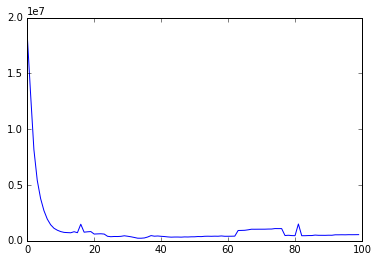

In [585]:
y_avgs = revdf_exnullrows.mean(axis=0)
xs = np.arange(len(y_avgs))
plt.plot(xs[:100], y_avgs[:100])

In [592]:
# Get rid of movies where there are over 100 weeks of revenue data (mostly IMAX movies)
revdf_exoutliers = revdf_exnullrows[revdf_exnullrows.count(axis=1) < 100]
len(revdf_exoutliers)

3635

In [465]:
moviedf.head()

,distributor,domestic total gross,genre,movie title,movieid,number of theaters,opening weekend revenue,production budget,rating,release date,runtime (mins),time in theaters (days),release month
0,Orion Pictures,90944400.0,Comedy,Dirty Rotten Scoundrels,1,1515.0,8129500.0,NaN,PG,1988-12-16,110.0,56.0,12.0
1,Fox,252358600.0,Action Thriller,Speed,2,2169.0,30088300.0,30000000.0,R,1994-06-10,116.0,70.0,6.0
2,Paramount,48884600.0,Comedy,The Out-of-Towners,3,2128.0,14084800.0,75000000.0,PG-13,1999-04-02,90.0,105.0,4.0
3,Universal,39263600.0,War Romance,Captain Corelli's Mandolin,4,1612.0,11081500.0,57000000.0,R,2001-08-17,129.0,63.0,8.0
4,Paramount,108640100.0,Comedy,"Planes, Trains and Automobiles",5,1684.0,15596500.0,NaN,R,1987-11-25,92.0,77.0,11.0


In [471]:
test1 = pd.DataFrame({'title': ['a','b','c','d'], 'score': [4,3,3,5],'movieid': [1,2,4,6]})

dd = {1: [11,23,23,2], 2:[121,14,123], 3:[12,21,1]}
test2 = pd.DataFrame.from_dict({k : pd.Series(v) for k,v in dd.items()}, 
                                     orient='index')

In [474]:
test2['decay rate'] = np.asarray([0.2,-0.6,0.02])
test2

,0,1,2,3,decay rate
1,11,23,23,2.0,0.20
2,121,14,123,NaN,-0.60
3,12,21,1,NaN,0.02


In [476]:
test1

,movieid,score,title
0,1,4,a
1,2,3,b
2,4,3,c
3,6,5,d


In [480]:
# test3 = pd.concat([test2['decay rate'], test2.index], axis=1)
# test3
# result = pd.merge(test1, test2['decay rate'], left_on='movieid', right_on='movieid', how='inner')
# result
test2_short = pd.DataFrame(test2['decay rate'], index=test2.index)
test2_short
test3 = pd.merge(test1, test2_short, left_on='movieid', right_index=True, how='inner')
test3

,movieid,score,title,decay rate
0,1,4,a,0.2
1,2,3,b,-0.6


In [593]:
decaydf = pd.DataFrame(revdf_exoutliers['decay rate'], index=revdf_exoutliers.index)
decaydf.head()

,decay rate
1,-0.206736
2,-0.230695
3,-0.319087
4,-0.587304
5,-0.715197


In [594]:
merged = pd.merge(moviedf, decaydf, left_on='movieid', right_index=True, how='inner')
merged.describe()

,domestic total gross,movieid,number of theaters,opening weekend revenue,production budget,runtime (mins),time in theaters (days),release month,decay rate
count,3.626000e+03,3626.000000,3593.000000,3.237000e+03,1.993000e+03,3625.000000,3626.000000,3626.000000,3626.000000
mean,8.998510e+07,1948.258687,2249.123852,2.375641e+07,5.548064e+07,108.251586,82.163265,6.989520,-0.385245
std,8.601357e+07,1125.669740,917.356115,2.313366e+07,4.627000e+07,18.180043,49.911313,3.448042,0.253029
min,1.263660e+07,1.000000,15.000000,4.960000e+04,1.500000e+04,40.000000,7.000000,1.000000,-2.631008
25%,3.640072e+07,979.250000,1508.000000,1.067720e+07,2.300000e+07,95.000000,42.000000,4.000000,-0.506399
50%,6.001080e+07,1943.500000,2310.000000,1.658650e+07,4.000000e+07,105.000000,77.000000,7.000000,-0.379061
75%,1.097310e+08,2918.750000,2956.000000,2.789960e+07,7.500000e+07,118.000000,112.000000,10.000000,-0.263687
max,1.114286e+09,3902.000000,4468.000000,2.479667e+08,3.000000e+08,227.000000,469.000000,12.000000,1.819528


In [599]:
merged.to_csv('csv/merged_table.csv',encoding='utf-8')

# Plot data (density and scatter plots) #

In [495]:
def plot_kde(df, category):
    dropped = df[category].dropna()
    density = gaussian_kde(dropped)
    xs = np.linspace(dropped.min(),dropped.max(),300)
    ys = density(xs)
    plt.plot(xs, ys)
    plt.title('PDF of ' + category)
    plt.ylabel('Probability')
    plt.xlabel(category)

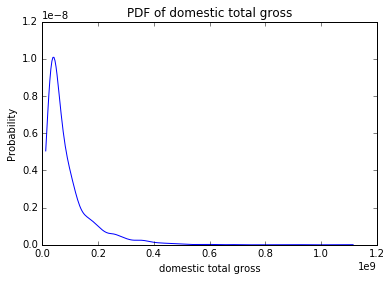

In [496]:
plot_kde(merged, 'domestic total gross')

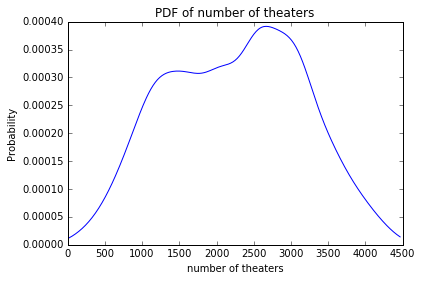

In [497]:
plot_kde(merged, 'number of theaters')

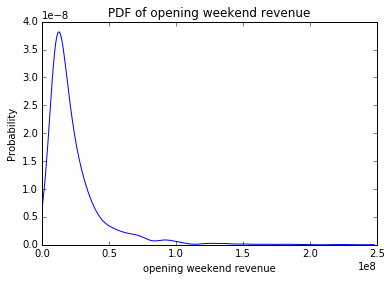

In [498]:
plot_kde(merged, 'opening weekend revenue')

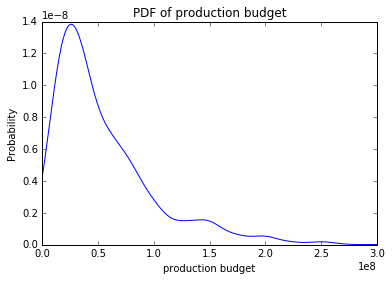

In [499]:
plot_kde(merged, 'production budget')

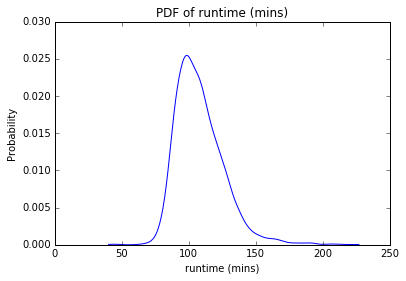

In [500]:
plot_kde(merged, 'runtime (mins)')

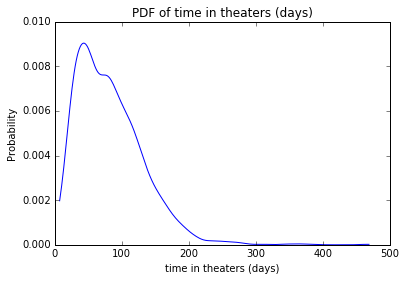

In [501]:
plot_kde(merged, 'time in theaters (days)')

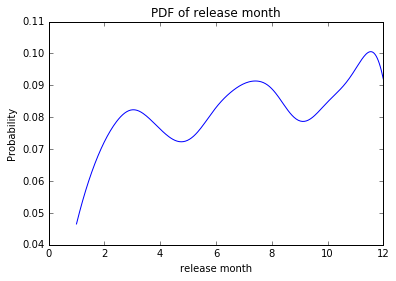

In [502]:
plot_kde(merged, 'release month')

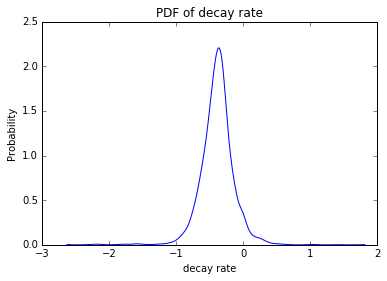

In [503]:
plot_kde(merged, 'decay rate')

In [552]:
def plot_bar(df, column):
    ys = df[column].value_counts(normalize=True, sort=False)
    xs = np.arange(len(ys))
    plt.figure(figsize=(18,5))
    plt.bar(xs, ys.values)
    plt.xticks(xs, ys.index, rotation=45)

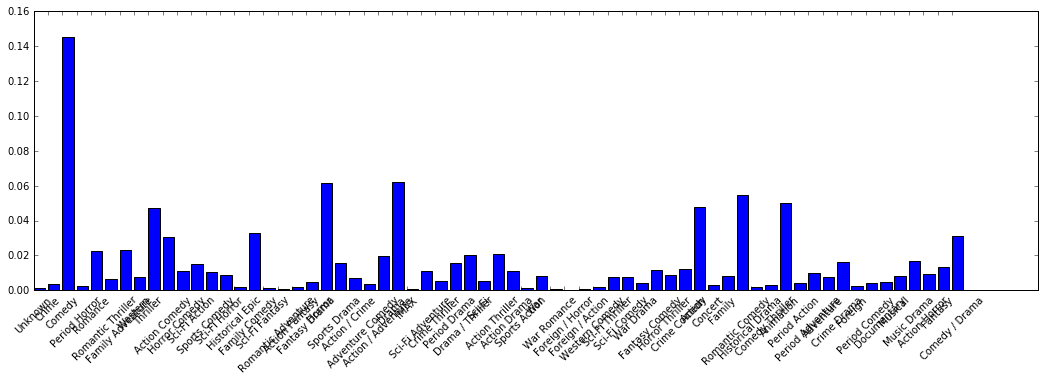

In [553]:
plot_bar(merged, 'genre')

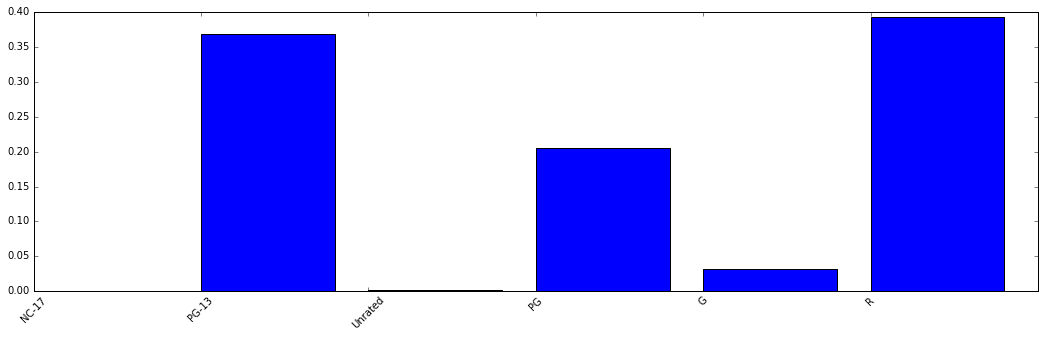

In [554]:
plot_bar(merged, 'rating')

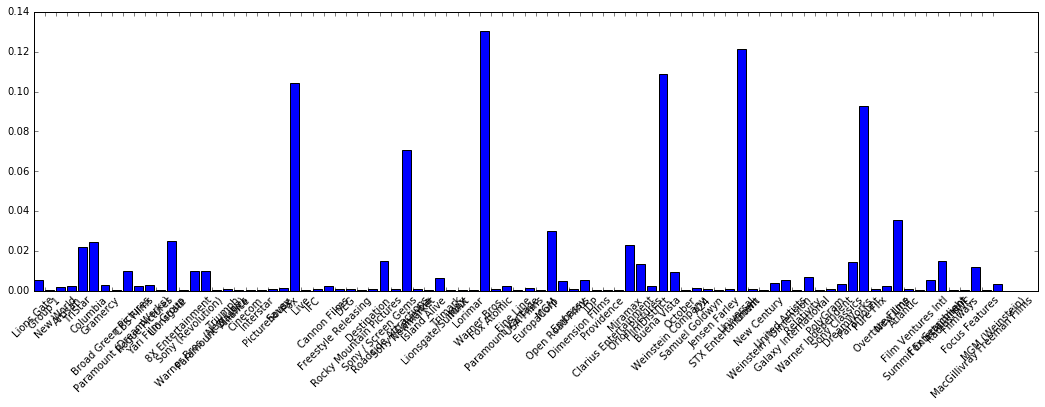

In [555]:
plot_bar(merged, 'distributor')

In [505]:
def plot_scatter(df, category):
    xs = df[category]
    ys = df['decay rate']
    plt.scatter(xs, ys)

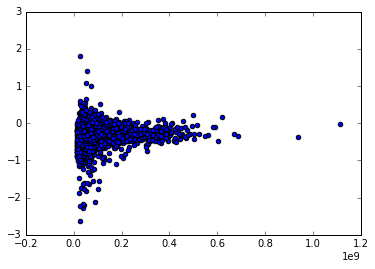

In [515]:
plot_scatter(merged, 'domestic total gross')

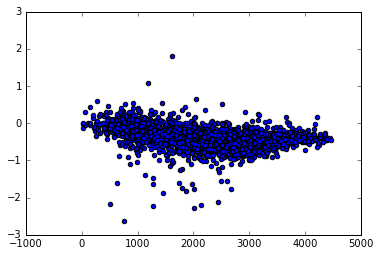

In [507]:
plot_scatter(merged, 'number of theaters')

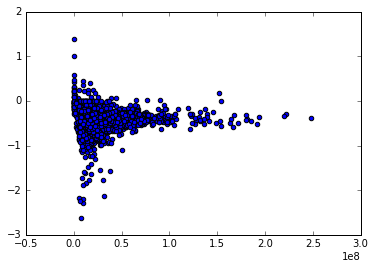

In [508]:
plot_scatter(merged, 'opening weekend revenue')

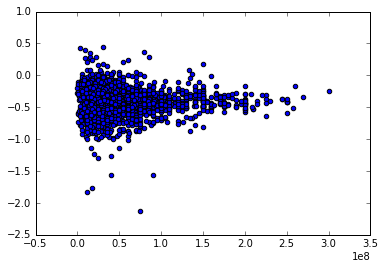

In [509]:
plot_scatter(merged, 'production budget')

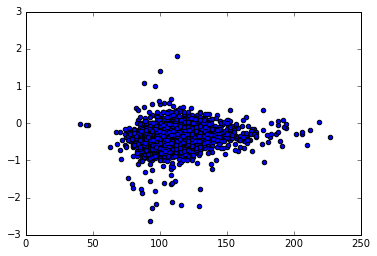

In [510]:
plot_scatter(merged, 'runtime (mins)')

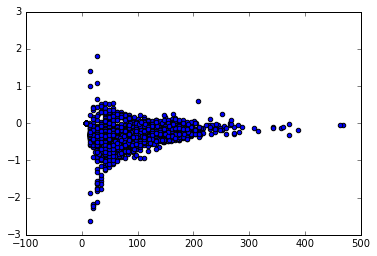

In [511]:
plot_scatter(merged, 'time in theaters (days)')

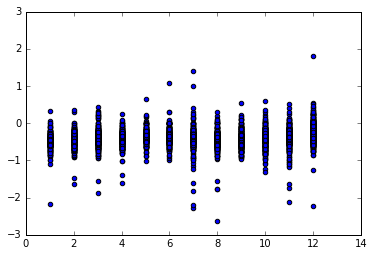

In [512]:
plot_scatter(merged, 'release month')

In [570]:
def plot_scatter_categorical(df, category):
    d = {}
    i = 0
    for c in df[category].unique():
        d[c] = i
        i += 1
    copy = df.copy(deep=True)
    copy[category + '_cat'] = copy[category].map(d)
    xs = copy[category + '_cat']
    ys = copy['decay rate']
    plt.scatter(xs, ys)

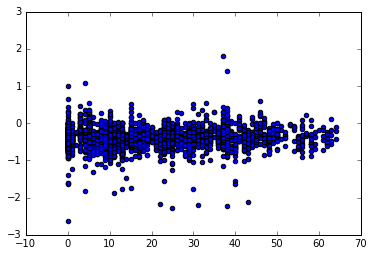

In [571]:
plot_scatter_categorical(merged, 'genre')

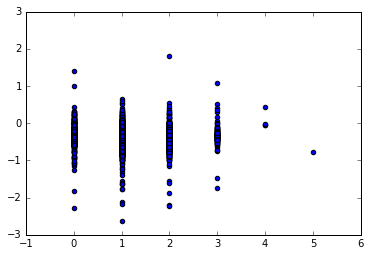

In [572]:
plot_scatter_categorical(merged, 'rating')

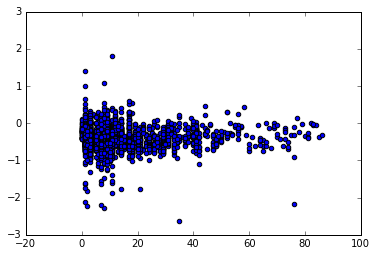

In [573]:
plot_scatter_categorical(merged, 'distributor')

In [517]:
merged.corr()

,domestic total gross,movieid,number of theaters,opening weekend revenue,production budget,runtime (mins),time in theaters (days),release month,decay rate
domestic total gross,1.000000,0.002110,0.372644,0.835386,0.485476,0.235816,0.413672,0.079406,0.186332
movieid,0.002110,1.000000,0.002020,0.003441,0.006711,-0.001098,0.023036,0.016712,0.006540
number of theaters,0.372644,0.002020,1.000000,0.593986,0.599704,0.012603,0.279060,-0.074095,-0.337709
opening weekend revenue,0.835386,0.003441,0.593986,1.000000,0.616695,0.239999,0.402478,-0.001529,0.030799
production budget,0.485476,0.006711,0.599704,0.616695,1.000000,0.305721,0.198416,0.023071,0.057094
runtime (mins),0.235816,-0.001098,0.012603,0.239999,0.305721,1.000000,0.141906,0.189662,0.131652
time in theaters (days),0.413672,0.023036,0.279060,0.402478,0.198416,0.141906,1.000000,0.106977,0.213982
release month,0.079406,0.016712,-0.074095,-0.001529,0.023071,0.189662,0.106977,1.000000,0.144514
decay rate,0.186332,0.006540,-0.337709,0.030799,0.057094,0.131652,0.213982,0.144514,1.000000


In [600]:
merged.head()

,distributor,domestic total gross,genre,movie title,movieid,number of theaters,opening weekend revenue,production budget,rating,release date,runtime (mins),time in theaters (days),release month,decay rate
0,Orion Pictures,90944400.0,Comedy,Dirty Rotten Scoundrels,1,1515.0,8129500.0,NaN,PG,1988-12-16,110.0,56.0,12.0,-0.206736
1,Fox,252358600.0,Action Thriller,Speed,2,2169.0,30088300.0,30000000.0,R,1994-06-10,116.0,70.0,6.0,-0.230695
2,Paramount,48884600.0,Comedy,The Out-of-Towners,3,2128.0,14084800.0,75000000.0,PG-13,1999-04-02,90.0,105.0,4.0,-0.319087
3,Universal,39263600.0,War Romance,Captain Corelli's Mandolin,4,1612.0,11081500.0,57000000.0,R,2001-08-17,129.0,63.0,8.0,-0.587304
4,Paramount,108640100.0,Comedy,"Planes, Trains and Automobiles",5,1684.0,15596500.0,NaN,R,1987-11-25,92.0,77.0,11.0,-0.715197


# Create models #

In [722]:
from patsy import dmatrices, dmatrix
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [750]:
renamed = merged.rename(columns={'distributor':'dist', 'domestic total gross': 'dom_tot_gross',
                                'movie title': 'title', 'number of theaters': 'num_theaters',
                                'opening weekend revenue': 'open_rev', 'production budget': 
                                'budget', 'release date': 'release', 'runtime (mins)': 'runtime',
                                'time in theaters (days)': 'time_theaters', 'release month': 'month',
                                'decay rate': 'decay'})

In [808]:
renamed.to_csv('csv/analysisdf.csv',encoding='utf-8')

In [751]:
renamed.head()

,dist,dom_tot_gross,genre,title,movieid,num_theaters,open_rev,budget,rating,release,runtime,time_theaters,month,decay
0,Orion Pictures,90944400.0,Comedy,Dirty Rotten Scoundrels,1,1515.0,8129500.0,NaN,PG,1988-12-16,110.0,56.0,12.0,-0.206736
1,Fox,252358600.0,Action Thriller,Speed,2,2169.0,30088300.0,30000000.0,R,1994-06-10,116.0,70.0,6.0,-0.230695
2,Paramount,48884600.0,Comedy,The Out-of-Towners,3,2128.0,14084800.0,75000000.0,PG-13,1999-04-02,90.0,105.0,4.0,-0.319087
3,Universal,39263600.0,War Romance,Captain Corelli's Mandolin,4,1612.0,11081500.0,57000000.0,R,2001-08-17,129.0,63.0,8.0,-0.587304
4,Paramount,108640100.0,Comedy,"Planes, Trains and Automobiles",5,1684.0,15596500.0,NaN,R,1987-11-25,92.0,77.0,11.0,-0.715197


In [752]:
y = renamed['decay']
y.head()

0   -0.206736
1   -0.230695
2   -0.319087
3   -0.587304
4   -0.715197
Name: decay, dtype: float64

In [714]:
renamed.drop('decay', axis=1, inplace=True)

In [753]:
X = renamed

In [754]:
# Split into reporting (30%) and training (70%)
X_train, X_report, y_train, y_report = train_test_split(X, y, 
                                                        test_size = 0.3,
                                                        random_state = 4444)

# X_train['y_train'] = y_train

In [755]:
# Split training data into training (60%) and testing (40%) 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                       test_size = 0.4,
                                                       random_state = 4444)

In [756]:
# Check lengths
print 'Training: ' + str(len(X_train) == len(y_train))
print 'Testing: ' + str(len(X_test) == len(y_test))
print 'Reporting: ' + str(len(X_report) == len(y_report))

Training: True
Testing: True
Reporting: True


In [757]:
X_train.head()

,dist,dom_tot_gross,genre,title,movieid,num_theaters,open_rev,budget,rating,release,runtime,time_theaters,month,decay
2125,Universal,84277700.0,Action / Crime,Miami Vice,2126,3026.0,34167500.0,135000000.0,R,2006-07-28,146.0,70.0,7.0,-0.668087
2491,Paramount,18043900.0,Comedy / Drama,Young Adult,2493,987.0,NaN,12000000.0,R,2011-12-09,94.0,77.0,12.0,-0.206543
40,Buena Vista,41145900.0,Comedy,Taking Care of Business,41,1176.0,7445500.0,NaN,R,1990-08-17,108.0,35.0,8.0,-0.282272
3376,Fox,197893100.0,Animation,The Croods,3378,4065.0,47816800.0,135000000.0,PG,2013-03-22,98.0,182.0,3.0,-0.320947
105,Atlantic,37211500.0,Horror Comedy,Night of the Comet,106,1098.0,9271100.0,NaN,PG-13,1984-11-16,95.0,42.0,11.0,-0.334983


### First Model: num_theaters, runtime, month, rating, genre ###

In [774]:
def create_Xy(data, y_category, X_categories, intercept=True):
    formula = y_category + ' ~ '
    for c in X_categories:
        formula = formula + c + ' + '
    formula = formula[:-3]
    if not(intercept):
        formula = formula + ' - 1'
    y, X = dmatrices(formula, data=data, return_type='dataframe')
    return y, X

In [788]:
features_1 = ['num_theaters','runtime','C(month)','rating','genre']
y1_train, X1_train = create_Xy(X_train,'decay',features_1, intercept=False)
y1_test, X1_test = create_Xy(X_train,'decay',features_1, intercept=False)
y1_report, X1_report = create_Xy(X_train,'decay',features_1, intercept=False)

In [789]:
model_1 = sm.OLS(y1_train, X1_train)
results_1 = model_1.fit()

In [790]:
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  decay   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     5.538
Date:                Mon, 18 Apr 2016   Prob (F-statistic):           5.66e-43
Time:                        17:36:49   Log-Likelihood:                 86.619
No. Observations:                1511   AIC:                            -13.24
Df Residuals:                    1431   BIC:                             412.4
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
C(month)[1.0]                  -0.4169      0.074     -5.647      0.000        -0.562    -0.272
C(month)[2.0]                  -0.3749      0.071     -5.251      0.000        -0.515    -0.235
C(month)[3.0]                  -0.3340      0.072     -4.629      0.000        -0.475    -0.192
C(month)[4.0]                  -0.3695      0.072     -5.160      0.000        -0.510    -0.229
C(month)[5.0]                  -0.2983      0.075     -3.976      0.000        -0.445    -0.151
C(month)[6.0]                  -0.3248      0.073     -4.428      0.000        -0.469    -0.181
C(month)[7.0]                  -0.3982      0.073     -5.443      0.000        -0.542    -0.255
C(month)[8.0]                  -0.3935      0.071     -5.519      0.000        -0.533    -0.254
C(month)[9.0]                  -0.3800      0.074     -5.167      0.000        -0.524    -0.236
C(month)[10.0]                 -0.3872      0.073     -5.339      0.000        -0.529    -0.245
C(month)[11.0]                 -0.3826      0.072     -5.294      0.000        -0.524    -0.241
C(month)[12.0]                 -0.2654      0.073     -3.611      0.000        -0.410    -0.121
rating[T.PG]                    0.0006      0.042      0.015      0.988        -0.082     0.083
rating[T.PG-13]                -0.0690      0.046     -1.490      0.136        -0.160     0.022
rating[T.R]                    -0.0532      0.047     -1.142      0.254        -0.145     0.038
rating[T.Unrated]               0.1144      0.089      1.289      0.198        -0.060     0.288
genre[T.Action / Adventure]     0.0197      0.057      0.343      0.732        -0.093     0.132
genre[T.Action / Crime]        -0.3479      0.089     -3.905      0.000        -0.523    -0.173
genre[T.Action Comedy]          0.0128      0.046      0.281      0.779        -0.077     0.102
genre[T.Action Drama]           0.0035      0.060      0.058      0.953        -0.115     0.122
genre[T.Action Fantasy]        -0.0221      0.139     -0.159      0.874        -0.295     0.251
genre[T.Action Horror]         -0.1412      0.066     -2.138      0.033        -0.271    -0.012
genre[T.Action Thriller]        0.0473      0.052      0.910      0.363        -0.055     0.149
genre[T.Adventure]              0.0737      0.075      0.983      0.326        -0.073     0.221
genre[T.Adventure Comedy]       0.0054      0.140      0.039      0.969        -0.268     0.279
genre[T.Animation]              0.1312      0.047      2.800      0.005         0.039     0.223
genre[T.Comedy]                 0.0348      0.033      1.044      0.297        -0.031     0.100
genre[T.Comedy / Drama]         0.0158      0.044      0.359      0.720        -0.070     0.102
genre[T.Comedy Thriller]        0.0293      0.101      0.290      0.772        -0.169     0.228
genre[T.Con

In [779]:
y1_pred_test = results_1.predict(X1_test)

In [780]:
r2_1 = r2_score(y1_test, y1_pred_test)
r2_1

0.2341612974319226

In [781]:
adjr2_1 = 1 - (1 - r2_1) * ((len(y1_test) - 1) / (len(y1_test) - len(X1_test.columns) - 1))
adjr2_1

0.2341612974319226

### Second Model: num_theaters, runtime, month, rating

In [782]:
features_2 = ['num_theaters','runtime','C(month)','rating']
y2_train, X2_train = create_Xy(X_train,'decay',features_2, intercept=False)
y2_test, X2_test = create_Xy(X_train,'decay',features_2, intercept=False)
y2_report, X2_report = create_Xy(X_train,'decay',features_2, intercept=False)

In [783]:
model_2 = sm.OLS(y2_train, X2_train)
results_2 = model_2.fit()

In [784]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  decay   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     19.09
Date:                Mon, 18 Apr 2016   Prob (F-statistic):           1.19e-52
Time:                        17:35:49   Log-Likelihood:                 33.630
No. Observations:                1511   AIC:                            -31.26
Df Residuals:                    1493   BIC:                             64.51
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
C(month)[1.0]        -0.3748      0.056     -6.633      0.000        -0.486    -0.264
C(month)[2.0]        -0.3060      0.054     -5.633      0.000        -0.413    -0.199
C(month)[3.0]        -0.2701      0.054     -5.012      0.000        -0.376    -0.164
C(month)[4.0]        -0.3072      0.054     -5.712      0.000        -0.413    -0.202
C(month)[5.0]        -0.2250      0.058     -3.868      0.000        -0.339    -0.111
C(month)[6.0]        -0.2621      0.055     -4.745      0.000        -0.370    -0.154
C(month)[7.0]        -0.3287      0.055     -5.995      0.000        -0.436    -0.221
C(month)[8.0]        -0.3320      0.054     -6.199      0.000        -0.437    -0.227
C(month)[9.0]        -0.3139      0.056     -5.563      0.000        -0.425    -0.203
C(month)[10.0]       -0.3108      0.055     -5.628      0.000        -0.419    -0.202
C(month)[11.0]       -0.3075      0.054     -5.683      0.000        -0.414    -0.201
C(month)[12.0]       -0.1817      0.056     -3.241      0.001        -0.292    -0.072
rating[T.PG]         -0.0579      0.039     -1.495      0.135        -0.134     0.018
rating[T.PG-13]      -0.1518      0.038     -3.978      0.000        -0.227    -0.077
rating[T.R]          -0.1663      0.038     -4.337      0.000        -0.241    -0.091
rating[T.Unrated]     0.1343      0.175      0.769      0.442        -0.208     0.477
num_theaters      -8.122e-05   7.01e-06    -11.586      0.000      -9.5e-05 -6.75e-05
runtime               0.0019      0.000      5.319      0.000         0.001     0.003
==============================================================================
Omnibus:                     1005.581   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26237.142
Skew:                          -2.697   Prob(JB):                         0.00
Kurtosis:                      22.688   Cond. No.                     7.94e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [785]:
y2_pred_test = results_2.predict(X2_test)

In [786]:
r2_2 = r2_score(y2_test, y2_pred_test)
r2_2

0.17851821354530384

In [787]:
adjr2_4 = 1 - (1 - r2_4) * ((len(y4_test) - 1) / (len(y4_test) - len(X4_test.columns) - 1))
adjr2_4

0.14375367340880763

### Third Model: num_theaters, runtime, month, genre

In [791]:
features_3 = ['num_theaters','runtime','C(month)','genre']
y3_train, X3_train = create_Xy(X_train,'decay',features_3, intercept=False)
y3_test, X3_test = create_Xy(X_train,'decay',features_3, intercept=False)
y3_report, X3_report = create_Xy(X_train,'decay',features_3, intercept=False)

In [792]:
model_3 = sm.OLS(y3_train, X3_train)
results_3 = model_3.fit()

In [793]:
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  decay   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     5.587
Date:                Mon, 18 Apr 2016   Prob (F-statistic):           3.39e-42
Time:                        17:37:42   Log-Likelihood:                 81.010
No. Observations:                1511   AIC:                            -8.020
Df Residuals:                    1434   BIC:                             401.7
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
C(month)[1.0]                  -0.4605      0.062     -7.448      0.000        -0.582    -0.339
C(month)[2.0]                  -0.4178      0.060     -7.017      0.000        -0.535    -0.301
C(month)[3.0]                  -0.3736      0.060     -6.239      0.000        -0.491    -0.256
C(month)[4.0]                  -0.4091      0.060     -6.769      0.000        -0.528    -0.291
C(month)[5.0]                  -0.3376      0.063     -5.336      0.000        -0.462    -0.214
C(month)[6.0]                  -0.3609      0.062     -5.826      0.000        -0.482    -0.239
C(month)[7.0]                  -0.4395      0.061     -7.226      0.000        -0.559    -0.320
C(month)[8.0]                  -0.4360      0.059     -7.388      0.000        -0.552    -0.320
C(month)[9.0]                  -0.4247      0.061     -6.959      0.000        -0.544    -0.305
C(month)[10.0]                 -0.4277      0.060     -7.107      0.000        -0.546    -0.310
C(month)[11.0]                 -0.4228      0.062     -6.830      0.000        -0.544    -0.301
C(month)[12.0]                 -0.3025      0.062     -4.879      0.000        -0.424    -0.181
genre[T.Action / Adventure]     0.0180      0.057      0.316      0.752        -0.094     0.130
genre[T.Action / Crime]        -0.3437      0.089     -3.851      0.000        -0.519    -0.169
genre[T.Action Comedy]          0.0150      0.046      0.329      0.743        -0.075     0.105
genre[T.Action Drama]           0.0046      0.060      0.077      0.939        -0.114     0.123
genre[T.Action Fantasy]        -0.0260      0.139     -0.186      0.852        -0.299     0.247
genre[T.Action Horror]         -0.1370      0.066     -2.074      0.038        -0.267    -0.007
genre[T.Action Thriller]        0.0513      0.052      0.985      0.325        -0.051     0.154
genre[T.Adventure]              0.1066      0.074      1.438      0.151        -0.039     0.252
genre[T.Adventure Comedy]       0.0166      0.140      0.119      0.905        -0.257     0.291
genre[T.Animation]              0.1900      0.040      4.707      0.000         0.111     0.269
genre[T.Comedy]                 0.0410      0.033      1.234      0.217        -0.024     0.106
genre[T.Comedy / Drama]         0.0215      0.044      0.491      0.623        -0.064     0.107
genre[T.Comedy Thriller]        0.0470      0.101      0.464      0.643        -0.152     0.246
genre[T.Concert]               -0.0215      0.122     -0.176      0.860        -0.261     0.218
genre[T.Crime]                 -0.0074      0.170     -0.044      0.965        -0.340     0.326
genre[T.Crime Comedy]          -0.0127      0.066     -0.191      0.848        -0.142     0.117
genre[T.Crime Drama]            0.0129      0.053      0.247      0.805        -0.090     0.116
genre[T.Cri

In [794]:
y3_pred_test = results_3.predict(X3_test)

In [795]:
r2_3 = r2_score(y3_test, y3_pred_test)
r2_3

0.22845410242627051

In [796]:
adjr2_3 = 1 - (1 - r2_3) * ((len(y3_test) - 1) / (len(y3_test) - len(X3_test.columns) - 1))
adjr2_3

0.22845410242627051

### Fourth Model: num_theaters, runtime, month

In [797]:
features_4 = ['num_theaters','runtime','C(month)']
y4_train, X4_train = create_Xy(X_train,'decay',features_4, intercept=False)
y4_test, X4_test = create_Xy(X_train,'decay',features_4, intercept=False)
y4_report, X4_report = create_Xy(X_train,'decay',features_4, intercept=False)

In [798]:
model_4 = sm.OLS(y4_train, X4_train)
results_4 = model_4.fit()

In [799]:
results_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  decay   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     20.03
Date:                Mon, 18 Apr 2016   Prob (F-statistic):           4.80e-44
Time:                        17:38:43   Log-Likelihood:                 6.2341
No. Observations:                1511   AIC:                             15.53
Df Residuals:                    1497   BIC:                             90.02
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
C(month)[1.0]     -0.4463      0.048     -9.341      0.000        -0.540    -0.353
C(month)[2.0]     -0.3722      0.046     -8.142      0.000        -0.462    -0.283
C(month)[3.0]     -0.3257      0.045     -7.307      0.000        -0.413    -0.238
C(month)[4.0]     -0.3679      0.045     -8.110      0.000        -0.457    -0.279
C(month)[5.0]     -0.2783      0.050     -5.621      0.000        -0.375    -0.181
C(month)[6.0]     -0.3116      0.047     -6.689      0.000        -0.403    -0.220
C(month)[7.0]     -0.3835      0.046     -8.404      0.000        -0.473    -0.294
C(month)[8.0]     -0.4044      0.044     -9.118      0.000        -0.491    -0.317
C(month)[9.0]     -0.3881      0.048     -8.161      0.000        -0.481    -0.295
C(month)[10.0]    -0.3776      0.046     -8.154      0.000        -0.468    -0.287
C(month)[11.0]    -0.3458      0.047     -7.320      0.000        -0.438    -0.253
C(month)[12.0]    -0.2282      0.047     -4.806      0.000        -0.321    -0.135
num_theaters   -7.795e-05   6.88e-06    -11.331      0.000     -9.14e-05 -6.45e-05
runtime            0.0012      0.000      3.318      0.001         0.000     0.002
==============================================================================
Omnibus:                      966.938   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23168.684
Skew:                          -2.576   Prob(JB):                         0.00
Kurtosis:                      21.479   Cond. No.                     5.63e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [800]:
y4_pred_test = results_4.predict(X4_test)

In [801]:
r2_4 = r2_score(y4_test, y4_pred_test)
r2_4

0.14818301332619732

In [802]:
adjr2_4 = 1 - (1 - r2_4) * ((len(y4_test) - 1) / (len(y4_test) - len(X4_test.columns) - 1))
adjr2_4

0.14818301332619732

## Create Minimum Viable Product Graphs

In [807]:
# Best model so far is Model 3
# fig = plt.figure(figsize=(10,100))
# fig = sm.graphics.plot_partregress_grid(results_3, fig=fig)

In [806]:
# fig, ax = plt.subplots(figsize=(10,100))
# fig = sm.graphics.plot_ccpr_grid(results_3, fig=fig)